## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [5]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [8]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

STOP_PATIENCES = [5, 10, 25]

In [9]:

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for stop_ratio in STOP_PATIENCES:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Stop ratio = %.6f" % (stop_ratio))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    earlystop = EarlyStopping(monitor="val_loss", 
                              patience=stop_ratio, 
                              verbose=1
                              )
    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystop]
         )

    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-stop-ratio-%s" % (str(stop_ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0721 14:33:05.469352 140200172681024 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 14:33:05.471759 140200172681024 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 14:33:05.500263 140200172681024 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 14:33:05.501871 140200172681024 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The n

Experiment with Stop ratio = 5.000000


W0721 14:33:05.755238 140200172681024 deprecation_wrapper.py:119] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 14:33:05.830590 140200172681024 deprecation.py:323] From /home/one/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 16/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.1528 - acc: 0.6039 - val_loss: 1.4624 - val_acc: 0.4862
Epoch 17/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.1301 - acc: 0.6124 - val_loss: 1.4497 - val_acc: 0.4978
Epoch 18/50
50000/50000 [==============================] - 5s 100us/step - loss: 1.1071 - acc: 0.6221 - val_loss: 1.4508 - val_acc: 0.4959
Epoch 19/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.0846 - acc: 0.6310 - val_loss: 1.4453 - val_acc: 0.5047
Epoch 20/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.0638 - acc: 0.6387 - val_loss: 1.4455 - val_acc: 0.4988
Epoch 21/50
50000/50000 [==============================] - 5s 102us/step - loss: 1.0434 - acc: 0.6442 - val_loss: 1.4503 - val_acc: 0.4951
Epoch 22/50
50000/50000 [==============================] - 5s 101us/step - loss: 1.0212 - acc: 0.6537 - val_loss: 1.4507 - val_acc: 0.4996
Epoch 23/50
50000/50000 [==

50000/50000 [==============================] - 5s 101us/step - loss: 0.7637 - acc: 0.7554 - val_loss: 1.5109 - val_acc: 0.4956
Epoch 36/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.7462 - acc: 0.7615 - val_loss: 1.5298 - val_acc: 0.4918
Epoch 37/50
50000/50000 [==============================] - 5s 102us/step - loss: 0.7268 - acc: 0.7679 - val_loss: 1.5323 - val_acc: 0.4906
Epoch 38/50
50000/50000 [==============================] - 5s 101us/step - loss: 0.7084 - acc: 0.7762 - val_loss: 1.5512 - val_acc: 0.4932
Epoch 39/50
50000/50000 [==============================] - 5s 103us/step - loss: 0.6900 - acc: 0.7843 - val_loss: 1.5377 - val_acc: 0.4893
Epoch 40/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.6704 - acc: 0.7933 - val_loss: 1.5564 - val_acc: 0.4859
Epoch 41/50
50000/50000 [==============================] - 5s 104us/step - loss: 0.6541 - acc: 0.7993 - val_loss: 1.5815 - val_acc: 0.4901
Epoch 42/50
50000/50000 [==============

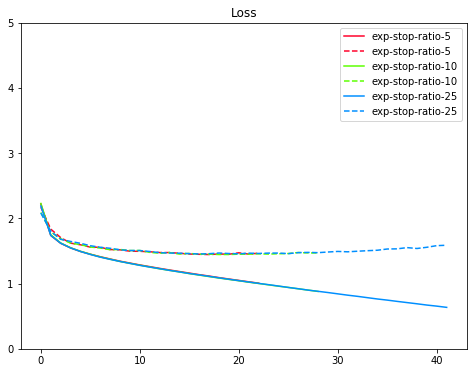

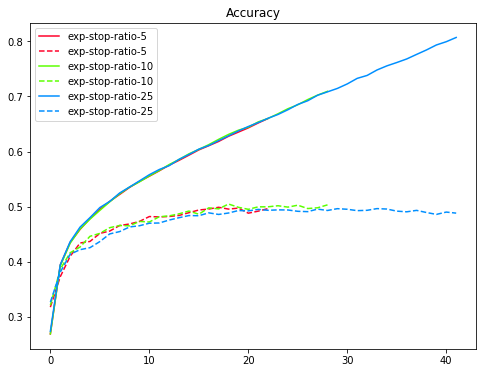

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()